In [1]:
# Type below commands when you run your jupyter notebook on google colab

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Below commands confirm that you are using GPU on google colab

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
# Importing necessary modules to alleviate our task

import re
import os
import folium
import codecs
import base64
import imageio
import nltk
import matplotlib
import mplcursors
import json
import spacy
import gensim
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import collections,itertools
from bs4 import BeautifulSoup
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# To set the size of label of x and y axis 

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams["axes.titlesize"]  = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'black'

In [3]:
# To get response by initiating a GET request from url "https://www.patinagroup.com"

response = requests.get("https://www.patinagroup.com")

In [4]:
# The content inside the response is organized as html format

soup = BeautifulSoup(response.text, features= "html.parser")

In [5]:
# Fetching the text from soup which is in html format. From this text we will collect necessary informations 
# about restaurants under patina group like Name of the restaurant, their Latitude and Longitude.

txt = soup.find_all("div", attrs= {'id':'main'})[0].get_text()

In [6]:
# It will return either list of restaurants or their Latitude and Longitude.

def getNameOfRestaurants(_list, featureName):
    if featureName == "Names":    
        restaurants = []
        for n in _list:
            restaurants.append(n.split(";")[0].split('"')[1])
        return restaurants 
    else:
        lat = []
        long = []
        for n in _list:
            la, lo = [i.split('"')[1] for i in n.split(";")[:-1]]
            lat.append(la)
            long.append(lo)
        return lat, long

In [7]:
# It is a helper function to function getNameOfRestaurants()

def getFeatures(featureName, txt):
    if featureName == "Names":
        listOfNames = re.findall("restaurant" + featureName + ".\d" + "." *50, txt)
        return getNameOfRestaurants(listOfNames, featureName)
    else:
        listOfLatLong = re.findall("restaurant" + featureName + ".\d" + "." *70, txt)
        return getNameOfRestaurants(listOfLatLong, featureName)

In [8]:
# Collecting name of all restaurant and their Latitude and Longitude.

nameOfRestaurants = getFeatures("Names", txt)
Latitudes, Longitudes = getFeatures("Latitudes", txt)

In [9]:
# Importing yelpapi module to get the important details about restaurant under patina group.

from yelpapi import YelpAPI

In [10]:
# Create your own api key in order to access all infromations about restautants from yelp platform

api_key = "Use your own api key"

In [11]:
# Instantiate an yelp_api object

yelp_api = YelpAPI(api_key)

In [12]:
print("Total number of restaurants are",len(nameOfRestaurants))

Total number of restaurants are 63


In [14]:
# Below function will accumulate reviews from all pages for each restaurant

def computation(url, dct, nameOfRestaurants, e):
  lst = []
  page = 0
  while True:
            response = requests.get(url + "start=" + str(page))
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, "html.parser")
                div_box = soup.findAll('div',attrs= {'itemprop':'review'})
                if div_box == list():
                    dct[nameOfRestaurants[e]] = lst
                    break
                else:
                    for d in div_box:
                        txt = d.find('p').getText()
                        txt = txt.replace('\r', '').replace('\n', '') # to remove "\n" from raw text
                        lst.append(txt)
                    page += 20
            else:
                print("Unable to get response!. The status code of response of url {} is {}\n.".format(url, response.status_code))
                break

In [15]:
# Below function will gather an url of restaurtant, rating and concept by passing arguments like nameOfRestaurant, latitude
# and longtitude.

def getReviews(nameOfRestaurants, dct, rating, newList, df_url, categories):
  
    for e in range(len(nameOfRestaurants)):
      
      if e in newList:
        url = df_url.loc[e][0] + "?"
        rating[nameOfRestaurants[e]] = df_url.loc[e][1]
        categories[nameOfRestaurants[e]] = df_url.loc[e][2]
        print(url)
        computation(url, dct, nameOfRestaurants, e)
      else:
        search_results = yelp_api.search_query(term = nameOfRestaurants[e], latitude =Latitudes[e],longitude=Longitudes[e])
        url = search_results["businesses"][0]["url"].split("?")[0]+ "?"
        rating[nameOfRestaurants[e]] = search_results["businesses"][0]['rating']
        categories[nameOfRestaurants[e]] = search_results["businesses"][0]['categories']
        print(url)
        computation(url, dct, nameOfRestaurants, e)

In [0]:
#### Don't execute 

# Around 10 restaurant's information are not fetched due to improper search initiated internally by YELP platform.
# So in order to go ahead in my purpose I collected all informations for 10 restautants manually from YELP.

# Execute this cell when you want to update reviews for all restaurtant.


dct = {}
rating = {}
categories = {}
newList = [57,30,27,22,20,11,10,9,46,6]
rat_lst = [0,3,2.5,3.5,4,3.5,3,3,3.5,4.5] 
# You have to feed this rating list (rat_lst) manually from yelp by checking order of restaurant in "10_restaurant_list.xlsx".

cat_lst = ["Venues & Event Spaces, Caterers", "Pizza, Italian", "American (Traditional), Food Stands, Coffee & Tea", "Sandwiches, Breakfast & Brunch, Cafes",
"Breakfast & Brunch",  "Soup, Sandwiches", "Italian", "Bakeries, Coffee & Tea, Sandwiches", "Mexican", "American (Traditional)"]

df_url = pd.read_excel("10_restaurant_list.xlsx") # This excel file has url of all 10 restaurants what I have fed manually.
df_url['index'] = newList
df_url['rating'] = rat_lst 
df_url['categories'] = cat_lst 
df_url.set_index('index', inplace= True)

In [0]:
#### Don't execute

# Run this cell when you want to update reviews for all restaurants under patina group. It takes around one and half hour to 
# collect all reviews.

getReviews(nameOfRestaurants, dct, rating, newList, df_url, categories)

https://www.yelp.com/biz/brasserie-8-1-2-new-york-2?
https://www.yelp.com/biz/brooklyn-botanic-garden-brooklyn-2?
https://www.yelp.com/biz/cafe-centro-new-york-8?
https://www.yelp.com/biz/catal-restaurant-anaheim-2?
https://www.yelp.com/biz/macys-chef-street-new-york?
https://www.yelp.com/biz/cocina-roja-los-angeles?
https://www.yelp.com/biz/colorado-kitchen-santa-monica-2?
https://www.yelp.com/biz/c-m-coffee-and-milk-at-lacma-los-angeles?
https://www.yelp.com/biz/c-m-coffee-and-milk-at-westwood-gateway-los-angeles?
https://www.yelp.com/biz/cucina-and-company-new-york?
https://www.yelp.com/biz/cucina-and-co-new-york-5?
https://www.yelp.com/biz/cucina-express-new-york?
https://www.yelp.com/biz/enzos-hideaway-lake-buena-vista-4?
https://www.yelp.com/biz/georges-cafe-costa-mesa?
https://www.yelp.com/biz/jakes-caf%C3%A9-buffalo-3?
https://www.yelp.com/biz/kendalls-brasserie-los-angeles?
https://www.yelp.com/biz/lacma-cafe-los-angeles?
https://www.yelp.com/biz/la-fonda-del-sol-new-york?
htt

In [69]:
# After reviews are collected I put all my reviews, their rating and concept in binary file so that I dont need to update all
# the informations till following week.


# np.save('new_dct.npy', dct) 
# np.save('new_rating.npy', rating) 
# np.save('new_categories.npy', categories) 

In [13]:
# Loading files

dct = np.load('new_dct.npy', allow_pickle = True).item()
rating = np.load('new_rating.npy', allow_pickle = True).item()
categories = np.load('new_categories.npy', allow_pickle = True).item()

In [14]:
# Pointing all restaurants under patina group on map by their latitude and longitude 
# Zoom in to get the full map of USA

from folium import FeatureGroup, LayerControl, Map, Marker

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
us_states = f'{url}/us-states.json'
geo_json_data = json.loads(requests.get(us_states).text)

m = folium.Map( zoom_start=4, tiles="stamentoner")

folium.GeoJson(geo_json_data).add_to(m)

feature_group = FeatureGroup()
for i,j,name in zip(Latitudes,Longitudes,nameOfRestaurants):
    Marker(location=[i,j],
       popup=name).add_to(feature_group)

feature_group.add_to(m)
LayerControl().add_to(m)
m

In [15]:
# I am assinging this because sometimes new restaurants are added in the original website of patina group and those restaurants 
# are not available instantly on yelp. So, In order to avoid exception I am using below command.

nameOfRestaurants = list(dct.keys()) 

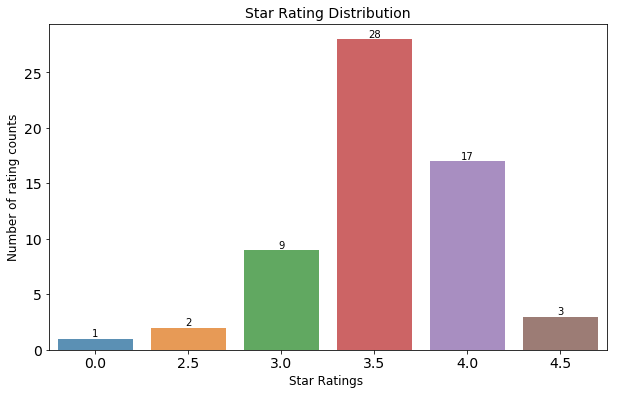

In [16]:
# Get the distribution of the ratings

rating_ = pd.Series(rating)
x = rating_.value_counts()
x = x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('Number of rating counts', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')

plt.show()

In [17]:
# Cleaning concept for each restaurant and extract which restaurant is possessing what kind of concept.

newList = [57,30,27,22,20,11,10,9,46,6]
cat_lst = {}
for i in range(len(nameOfRestaurants)):
  if i in newList:
    cat_lst[nameOfRestaurants[i]] = categories[nameOfRestaurants[i]]
  else:
    ls = []
    for j in categories[nameOfRestaurants[i]]:
      ls.append(j['title'])
    cat_lst[nameOfRestaurants[i]] = ls
    
    
cat = []
for i in cat_lst.values():
  if type(i) == list:
    
    cat += i
  else:
    cat += [j.strip() for j in i.split(',')]
    

concept = {}
for i,j in zip(cat_lst.values(),nameOfRestaurants):
  if type(i) == list:
    
    concept[j] = ','.join(i)
  else:
    concept[j] = i    
    
    
conceptList = list(pd.Series(cat).unique())


restFallInconcept = {}
for i in conceptList:
    for j,k in zip(list(concept.keys()), list(concept.values())):
        if i in k:
            if i not in restFallInconcept:
                restFallInconcept[i] = []
                restFallInconcept[i].append(j)
            else:
                restFallInconcept[i].append(j)

In [117]:
# z = pd.DataFrame(columns= ["Concept","Name of Restaurant"])
# ind = 0
# for i in list(restFallInconcept.keys()):
#     for e in restFallInconcept[i]:
#         z.loc[ind] = [i,e]
#         ind +=1
#z.to_excel('concept.xlsx')

In [18]:
# Below function will help to plot bar graph plot 

def getGraph(feature, _title, y_label, x_label, extra_info, figsize):
  a,b = figsize
  dt = pd.Series(feature).apply(lambda i: round(i, 2))
  plt.figure(figsize=(a,b))
  ax = sns.barplot(dt.values,dt.index, alpha=0.9)
  plt.title(_title,fontsize=20,color="BLACK",fontweight='bold')
  plt.ylabel(y_label,fontsize=20,fontweight='bold')
  plt.xlabel(x_label, fontsize=20,fontweight='bold')
  if extra_info == '%':
    for v in range(len(dt)):
      plt.text(dt[v],v,"  "+str(dt.values[v]) + "% Out of " + str(counts[list(feature.keys())[v]]) +" reviews",fontsize=10,color="BLACK")
  elif extra_info == "star":
    for v in range(len(dt)):
      plt.text(dt[v],v,str(dt.values[v]),fontsize=10,color="BLACK")
  else:
    for v in range(len(dt)):
      plt.text(dt[v],v,"  " + str(dt.values[v]),fontsize=14,color="BLACK")
  plt.show()

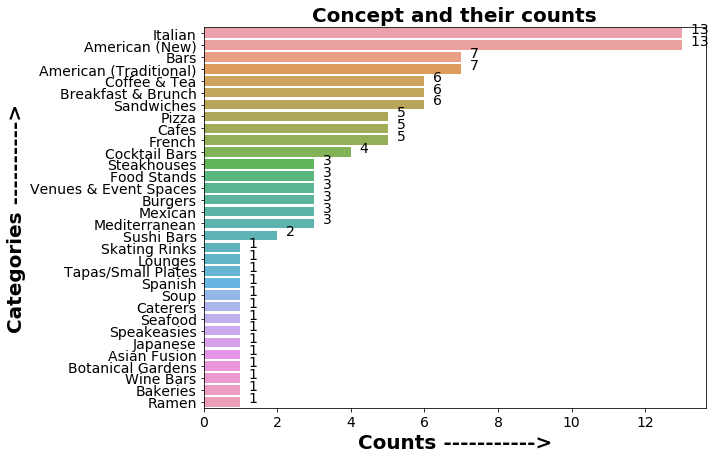

In [19]:
# Plotting counts of all concepts

title = "Concept and their counts"
y_label = 'Categories ---------->'
x_label = 'Counts ----------->'
extra_info = ''
figsize=[9,7]
getGraph(pd.Series(cat).value_counts(), title, y_label, x_label, extra_info, figsize)

In [20]:
# Categorizing very negative, negative, neutral, positive and very positive on the basis of polarity value.

def getComment(p):
  if -1 <= p < -0.5:
    return "very negative"
  elif -0.5 <= p < -0.1:
    return "negative"
  elif -0.1 <= p < 0.2:
    return "okay"
  elif 0.2 <= p < 0.6:
    return "positive"
  else:
    return "very positive"

In [21]:
# Saving essential parameters like reviews for all categories and their counts

# Counts
vp={}
p={}
o={}
n={}
vn={}

very_positive = {}
positive = {}
okay = {}
negative = {}
very_negative = {}

# Reviews

rev_very_pos = {}
rev_pos = {}
rev_very_neg = {}
rev_neg = {}
rev_okay = {}

for i in range(len(nameOfRestaurants)):
  
  try:
    
      df = pd.DataFrame(dct[nameOfRestaurants[i]],columns = ['Review'])
      df[['polarity', 'subjectivity']] = df['Review'].apply(lambda text: pd.Series(TextBlob(text).sentiment))
      df['feedback'] = df['polarity'].apply(getComment)
      
      rev_very_pos[nameOfRestaurants[i]] = list(df[df['feedback']=='very positive'].Review)
      very_good = len(rev_very_pos[nameOfRestaurants[i]])
      very_positive[nameOfRestaurants[i]] = (very_good / df.shape[0] ) * 100
      vp[nameOfRestaurants[i]] = very_good
    
      rev_pos[nameOfRestaurants[i]] = list(df[df['feedback']=='positive'].Review)
      good = len(rev_pos[nameOfRestaurants[i]])
      positive[nameOfRestaurants[i]] = (good / df.shape[0] ) * 100
      p[nameOfRestaurants[i]] = good
      
      rev_okay[nameOfRestaurants[i]] = list(df[df['feedback']=='okay'].Review)
      neutral = len(rev_okay[nameOfRestaurants[i]])
      okay[nameOfRestaurants[i]] = (neutral / df.shape[0] ) * 100
      o[nameOfRestaurants[i]] = neutral
      
      rev_neg[nameOfRestaurants[i]] = list(df[df['feedback']=='negative'].Review)
      bad = len(rev_neg[nameOfRestaurants[i]])
      negative[nameOfRestaurants[i]] = (bad / df.shape[0] ) * 100
      n[nameOfRestaurants[i]] = bad
      
      rev_very_neg[nameOfRestaurants[i]] = list(df[df['feedback']=='very negative'].Review)
      very_bad = len(rev_very_neg[nameOfRestaurants[i]])
      very_negative[nameOfRestaurants[i]] = (very_bad / df.shape[0] ) * 100
      vn[nameOfRestaurants[i]] = very_bad
      
      #names = ['Strong Positive', 'Positive', 'Neutral', 'Negative', 'Strong Negative']
      #counts = [very_good, good, neutral, bad, very_bad]

      #fig = sns.barplot(x="Feedbacks", y="Counts", data= {"Feedbacks":names,"Counts":counts})
      #fig.set(xlabel='Feedbacks----->', ylabel='Number of Reviews----->', title = nameOfRestaurants[i])
      #fig.figure.savefig(nameOfRestaurants[i] + ".png")
      #plt.show(fig)
      
  except KeyError:
      pass

In [22]:
# Importing important modules to create dashboard

import dash
import dash_core_components as dcc
import dash_html_components as html

In [23]:
# Importing plotly and its modules which will help in dashboard to create desirable plot

import plotly.graph_objs as go
import plotly
from plotly.graph_objs import *

In [24]:
# Making dashboard app to show all informations about each restaurant under patina group.Like number of positive, negative
# reviews, rating.

app = dash.Dash("Patina Group")


# Populating layout with HTML and graph components
app.layout = html.Div([
    html.H2("Patina Group Restaurants"),
    html.Div(
        [
            dcc.Dropdown(
                id="RESTAURANT",
                options=[{
                    'label': i,
                    'value': i
                } for i in nameOfRestaurants],
                value='restaurant'),
        ],
        style={'width': '25%'}),
    dcc.Graph(id='Bar-graph'),
])


# Adding callbacks to support the interactive componets

@app.callback(
    dash.dependencies.Output('Bar-graph', 'figure'),
    [dash.dependencies.Input('RESTAURANT', 'value')])


def update_graph(name):
    
    trace0 = go.Bar(
    x= ["Very Negative"],
    y = [vn[name]]
    ,
    marker=dict(
        color='red'
    )
) 
    
    trace1 = go.Bar(
    x= ["Negative"],
    y = [n[name]]
    ,
    marker=dict(
        color='blue'
    )
)
    
    trace2 = go.Bar(
    x= ["Neutral"],
    y = [o[name]]
    ,
    marker=dict(
        color='green'
    )
)
    
    trace3 = go.Bar(
    x= ["Positive"],
    y = [p[name]]
    ,
    marker=dict(
        color='orange'
    )
)
    
    trace4 = go.Bar(
    x= ["Very Positive"],
    y = [vp[name]]
    ,
    marker=dict(
        color='black'
    )
)
    tot = vn[name] + n[name] + o[name] + p[name] + vp[name]
    per_vn = np.around(100*(vn[name]/tot), decimals=2)
    per_n = np.around(100*(n[name]/tot), decimals=2)
    per_o = np.around(100*(o[name]/tot), decimals=2)
    per_p = np.around(100*(p[name]/tot), decimals=2)
    per_vp = np.around(100*(vp[name]/tot), decimals=2)
    return {
        'data': [trace0, trace1, trace2, trace3, trace4],
        'layout':
        go.Layout(xaxis={'title': 'Feedbacks-------->'},
                yaxis={'title': 'Number of Reviews-------->'},
            title= "( "+name + " | Total reviews : " + str(tot)+" | Very Postive : "+str(per_vp)+"%"+ 
                  " | Postive : "+str(per_p)+"%"+" | Neutral : "+str(per_o)+"%"+
                  " | Negative : "+str(per_n)+"%"+" | Very Negative : "+str(per_vn)+"%"+
                  " | Rating : "+str(rating[name])+" )",barmode='stack',)
    }


if __name__ == '__main__':
    app.server.run(debug  = False)

 * Serving Flask app "Patina Group" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Aug/2019 17:55:03] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 17:55:04] "GET /_dash-component-suites/dash_renderer/react@16.8.6.min.js?v=1.0.0&m=1561357055 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 17:55:04] "GET /_dash-component-suites/dash_renderer/prop-types@15.7.2.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 17:55:04] "GET /_dash-component-suites/dash_core_components/highlight.pack.js?v=1.0.0&m=1561357059 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 17:55:04] "GET /_dash-component-suites/dash_renderer/react-dom@16.8.6.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 17:55:04] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js?v=1.0.0&m=1561357065 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 17:55:04] "GET /_dash-component-suites/dash_renderer/dash_renderer.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 1

In [25]:
# Calculating total number of reviews

counts = {}
for i in range(len(nameOfRestaurants)):
  counts[nameOfRestaurants[i]] = len(dct[nameOfRestaurants[i]])

In [26]:
print("Total number of reviews are {} from all restaurants.".format(pd.Series(list(counts.values())).sum()))

Total number of reviews are 23344 from all restaurants.


In [27]:
# Creating a dataframe with Name Of Restaurant,Counts,and Rating.

countRating = pd.DataFrame(zip(counts.keys(),counts.values(),rating.values()), columns=['Name Of Restaurant','Counts','Rating'])
countRating.head()

,Name Of Restaurant,Counts,Rating
0,Brasserie 8½,432,3.5
1,Brooklyn Botanic Garden,734,4.5
2,Cafe Centro,150,3.5
3,Catal Restaurant,1700,4.0
4,Chef Street,29,3.0


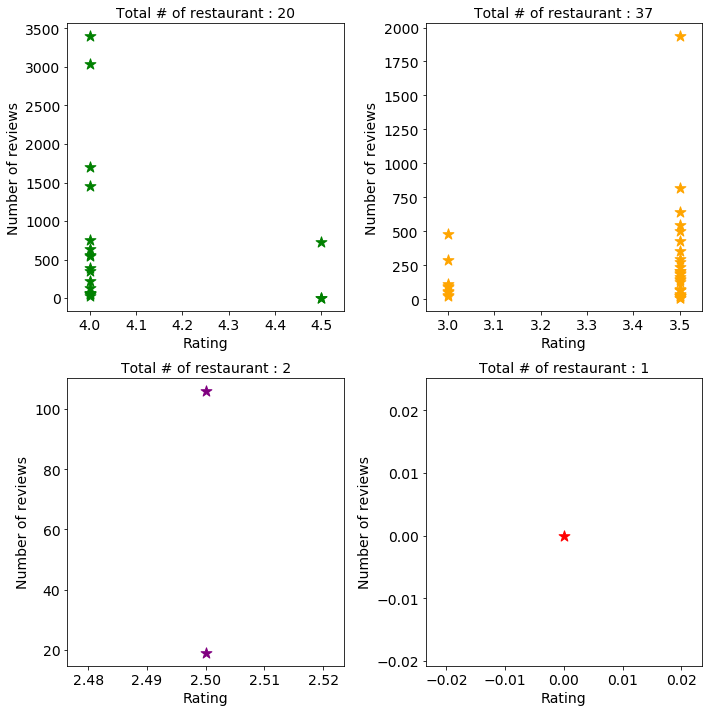

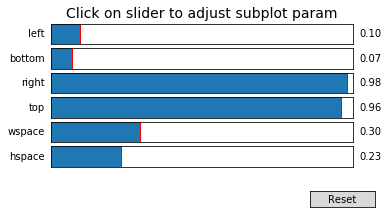

In [28]:
# Plotting graphs with different range of rating of various restaurants versus review counts

plt.figure(figsize=(10,10))
plt.subplot(221)
quad1 = countRating[(countRating['Rating'] >=4)].reset_index(drop=True)
plt.scatter(quad1['Rating'],quad1['Counts'],c ='green',marker ='*',s=130)
plt.title("Total # of restaurant : " + str(quad1.shape[0]))
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.subplot(222)
quad2 = countRating[(countRating['Rating'] >=3) & (countRating['Rating'] <4)].reset_index(drop=True)

plt.scatter(quad2['Rating'],quad2['Counts'],c ='orange',marker ='*',s=130)
plt.title("Total # of restaurant : " + str(quad2.shape[0]))
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.subplot(223)
quad3 = countRating[(countRating['Rating'] >=2) & (countRating['Rating'] <3)].reset_index(drop=True)

plt.scatter(quad3['Rating'],quad3['Counts'],c ='purple',marker ='*',s=130)
plt.title("Total # of restaurant : " + str(quad3.shape[0]))
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.subplot(224)
quad4 = countRating[(countRating['Rating'] >=0) & (countRating['Rating'] <2)].reset_index(drop=True)
plt.scatter(quad4['Rating'],quad4['Counts'],c ='red',marker ='*',s=130)
plt.title("Total # of restaurant : " + str(quad4.shape[0]))
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.tight_layout()
plt.subplot_tool()
plt.show()

In [29]:
# Below function assists to plot bar graph with precise information about restaurants on the basis of rating.

def getRevRating(quad, condition, figsize_):
    plt.figure(figsize= figsize_)
    sns.barplot(quad['Counts'],quad['Name Of Restaurant'])
    plt.title("Total # of restaurant : "+str(quad.shape[0])+" | "+condition+" | "+str(np.around((quad.shape[0]/60)*100,2))+"%")
    plt.xlabel('Number of reviews')
    plt.ylabel('Name Of Restaurant')
    for v in range(len(quad)):
          plt.text(quad['Counts'][v],v,"  "+str(quad['Counts'][v])+" | Rating : "+str(quad['Rating'][v]),
                   fontsize=13,color="BLACK")

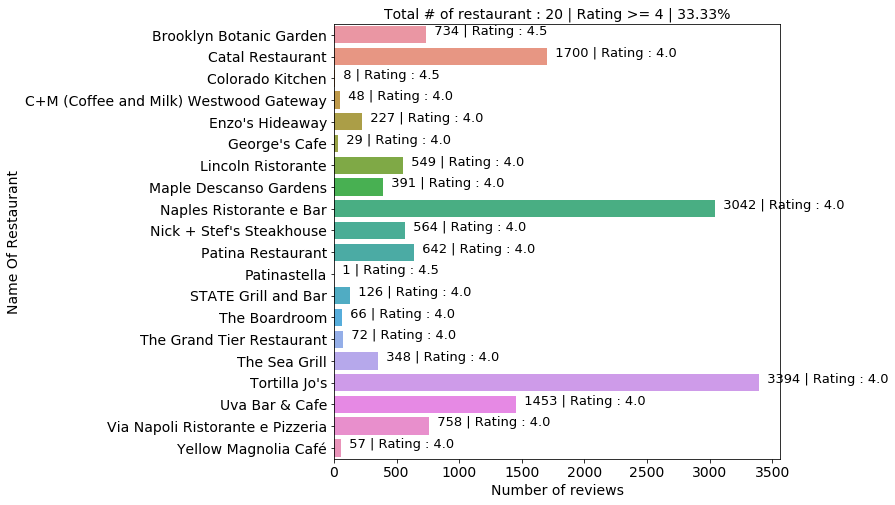

In [30]:
# Plotting all restaurants whose rating >= 4.

getRevRating(quad1,"Rating >= 4", (8,8))

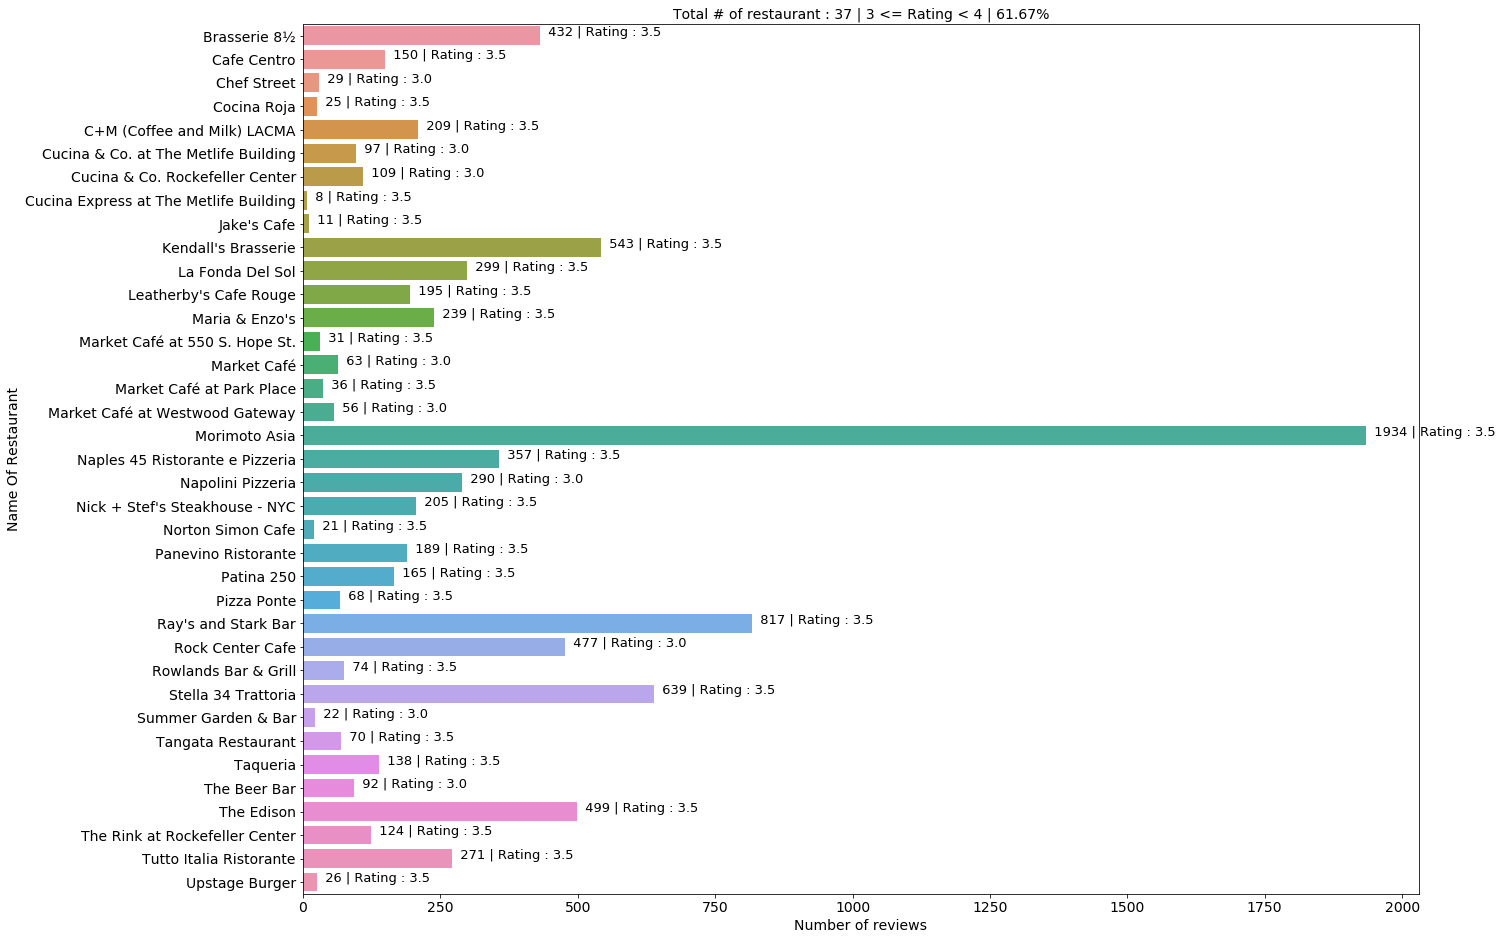

In [31]:
# Plotting all restaurants whose rating lies between [3, 4).

getRevRating(quad2, "3 <= Rating < 4", (20,16))

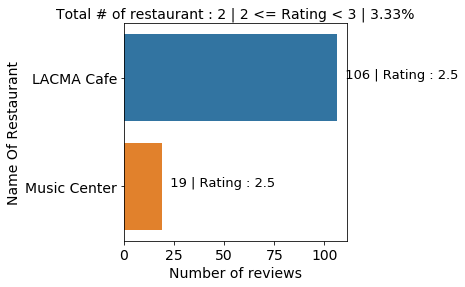

In [32]:
# Plotting all restaurants whose rating lies between [2, 3).

getRevRating(quad3, "2 <= Rating < 3",(4,4))

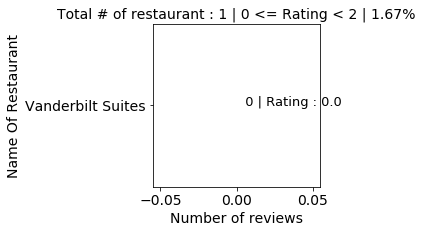

In [33]:
# Plotting all restaurants whose rating lies between [0, 2).

getRevRating(quad4, "0 <= Rating < 2", (3,3))

In [36]:
# Execute two or three times this cell so that interactive plot pops up properly when the following cell will be executed.

%matplotlib notebook 

<IPython.core.display.Javascript object>


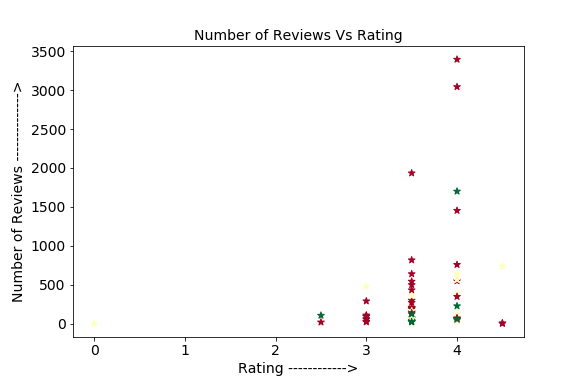

In [37]:
# Plotting interactive plot where which restauant is having what rating and review counts.

x = list(rating.values())
y = list(counts.values())
names = pd.Series(nameOfRestaurants)
c = np.random.randint(1,5,size= 60)

norm = plt.Normalize(2,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c, s=50,marker= "*", cmap=cmap, norm=norm)
annot = ax.annotate("", xy=(0,0), xytext=(50,30),textcoords="offset pixels",
                    bbox=dict(boxstyle="square", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
plt.xlabel("Rating ------------>")
plt.ylabel("Number of Reviews -------------->")
plt.title("Number of Reviews Vs Rating")

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    for n in ind["ind"]:
        text = names[n] 
        annot.set_text(text)
    #annot.get_bbox_patch().set_facecolor(cmap(c[ind["ind"][0]]))
    annot.get_bbox_patch().set_alpha(0.02)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

In [38]:
%matplotlib inline

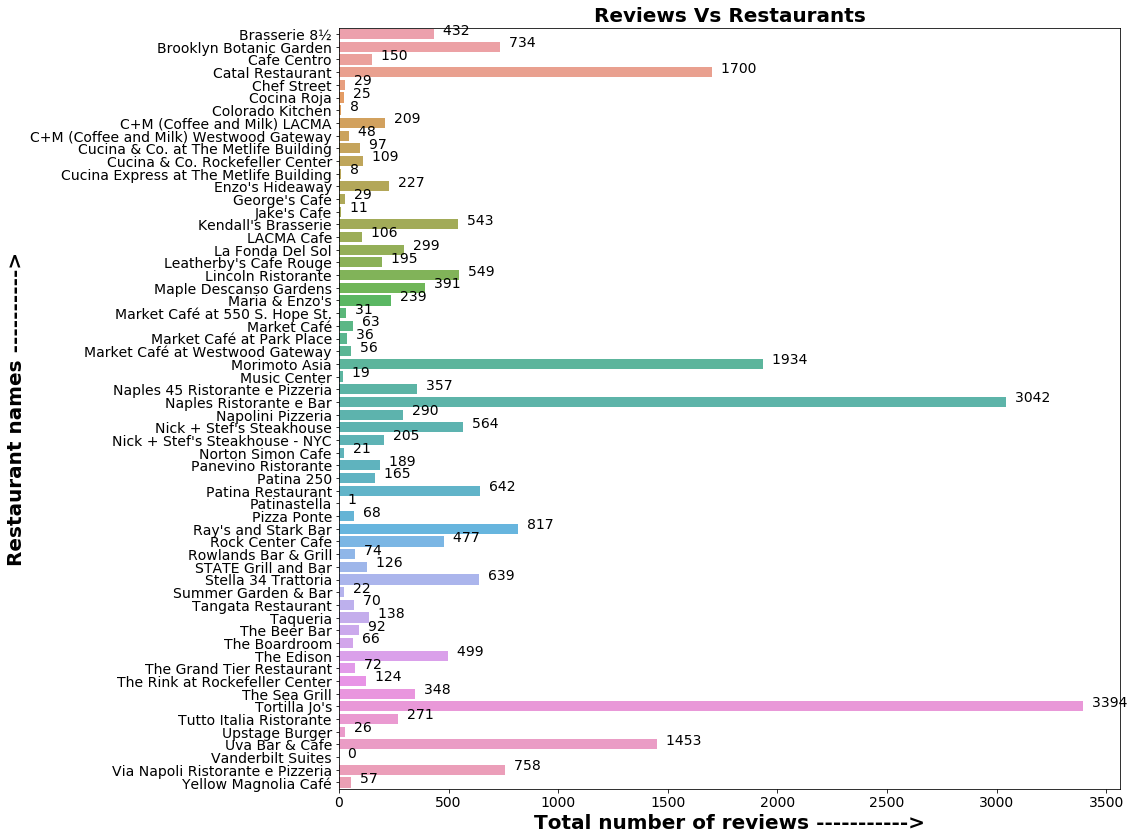

In [39]:
# Plotting reviews versus restaurant

title = "Reviews Vs Restaurants"
y_label = 'Restaurant names ---------->'
x_label = 'Total number of reviews ----------->'
extra_info = ''
figsize=[14,14]
getGraph(counts, title, y_label, x_label, extra_info, figsize)

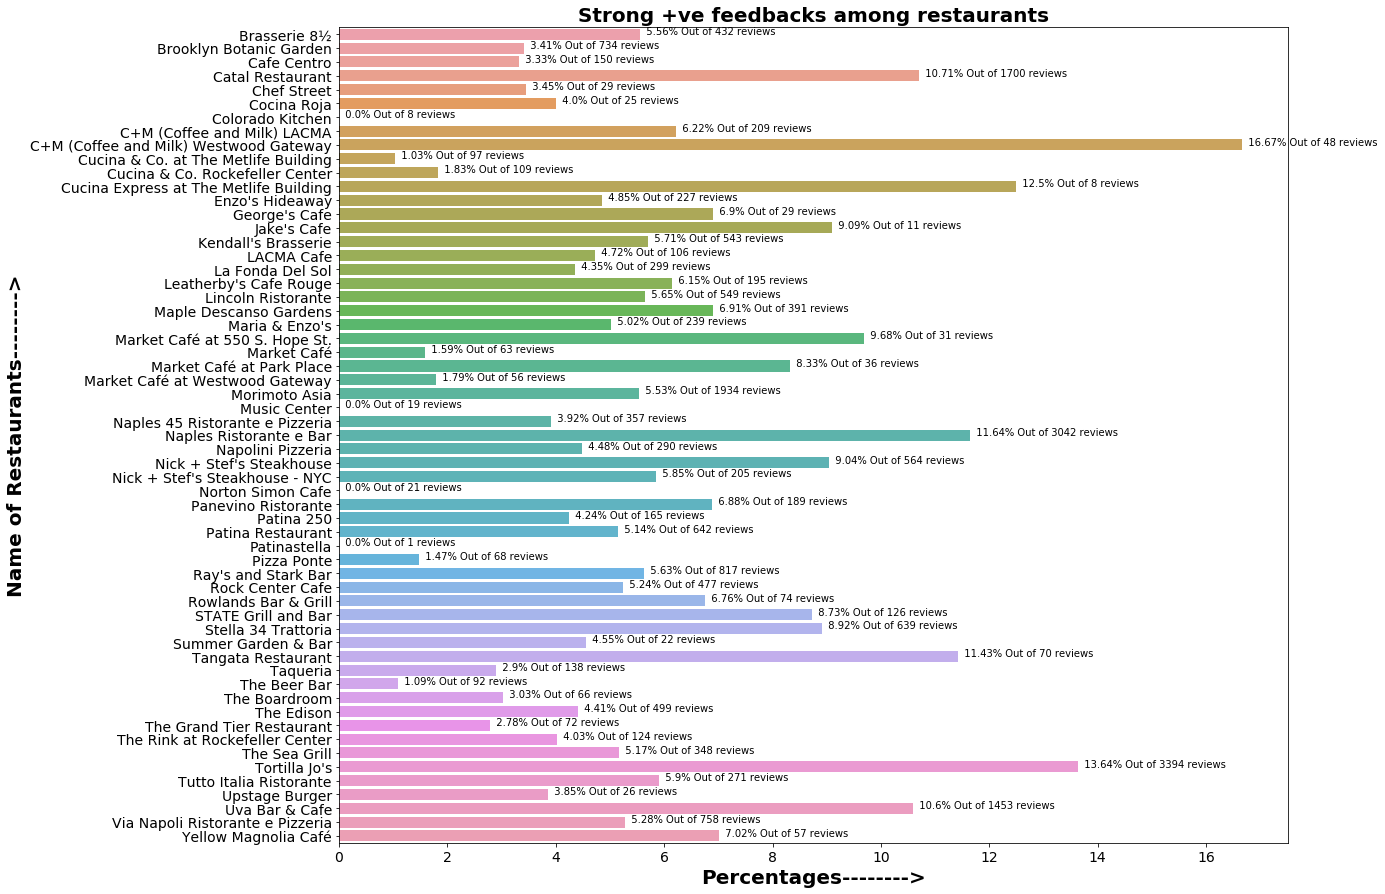

In [40]:
# plotting very positive feedbacks in percentage versus all restaurants

title = "Strong +ve feedbacks among restaurants"
y_label = "Name of Restaurants-------->"
x_label = "Percentages-------->"
extra_info = "%"
figsize=[17,15]
getGraph(very_positive, title, y_label, x_label, extra_info, figsize)

In [41]:
# Importing below modules to prepocess reviews 

from wordcloud import WordCloud,STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

In [42]:
# Below function will collect either positive words or negative words from list of reviews for each restaurant.

def getWords(rev_name, rev_name_1, words_c, com, cond):
    sid = SentimentIntensityAnalyzer()
    lmtzr = WordNetLemmatizer()
    for j,k in zip(list(rev_name.keys()), list(rev_name_1.keys())):
        filtered_words = []
        if rev_name[j] == list():
            pass
        else:
            
            dr  = pd.DataFrame(rev_name[j], columns = ['reviews'])
            words = ' '.join(dr.reviews)
            cleaned_word = " ".join([word for word in words.split()])

            for word, tag in TextBlob(cleaned_word.lower()).tags:
                if tag in ('NNP', 'VBG','NN', 'NNS','JJ','JJR','VBN','VBZ','VB','JJS') :
                    if eval(str(sid.polarity_scores(word)['compound']) + cond):
                        filtered_words.append(lmtzr.lemmatize(word,'v')) 
                        
        if rev_name_1[k] == list():
            pass
        else:
            
            dr_  = pd.DataFrame(rev_name_1[k], columns = ['reviews'])
            words_ = ' '.join(dr_.reviews)
            cleaned_word_ = " ".join([word for word in words_.split()])

            for word_, tag_ in TextBlob(cleaned_word_.lower()).tags:
                if tag_ in ('NNP', 'VBG','NN', 'NNS','JJ','JJR','VBN','VBZ','VB','JJS') :
                    if eval(str(sid.polarity_scores(word_)['compound']) + cond):
                        filtered_words.append(lmtzr.lemmatize(word_,'v')) 
                        
        words_count = collections.Counter(itertools.chain.from_iterable(x.split() for x in ' '.join(filtered_words).split()))
        words_c[j] = words_count
        com[j] = " ".join(set(filtered_words))

In [43]:
# Gathering all negative words from negative and very negative review list on the basis of polarity value <= -0.2.

words_c_neg = {}
comment_neg = {}
neg_cond = "<= -0.2"
getWords(rev_very_neg, rev_neg, words_c_neg, comment_neg, neg_cond)

In [44]:
# Gathering all positive words from positive and very positive review list on the basis of polarity value >= 0.4.

words_c_pos = {}
comment_pos = {}
pos_cond = ">= 0.4"
getWords(rev_very_pos, rev_pos, words_c_pos, comment_pos, pos_cond)

In [45]:
# Below function returns mask of any image. To get a clear word cloud, always pass HD image.

def getEncode(file):
    with open(file, "rb") as image_file:
        mask = base64.b64encode(image_file.read())
    f1 = open(file, "wb")
    f1.write(codecs.decode(mask,'base64'))
    f1.close()
    img1 = imageio.imread(file)
    return img1

In [46]:
# It returns word cloud.

def getWordCloud(rev_name, mask, name,figsize):
  cleaned_word = rev_name
  wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',mask=mask,colormap='prism').generate(cleaned_word)
  plt.figure(figsize=figsize)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.title(name,fontdict={'fontsize': 20})
  plt.show()

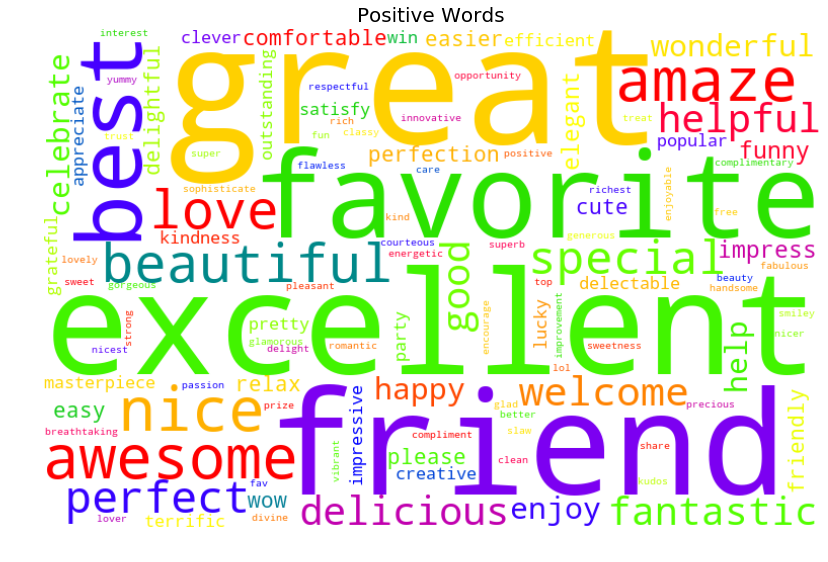

In [47]:
# Word cloud for positive words for Patina 250 restaurant

getWordCloud(' '.join(list(words_c_pos['Patina 250'].keys())), getEncode('thumb.jpg'),"Positive Words",figsize=(14,12))

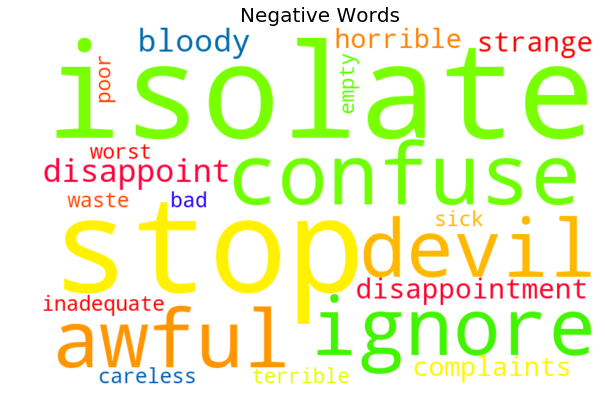

In [48]:
# Word cloud for negative words for Patina 250 restaurant

getWordCloud(' '.join(list(words_c_neg['Patina 250'].keys())), getEncode('thumb.jpg'), "Negative Words",figsize=(10,8))

In [49]:
# Making dashboard app for showing positive and negative words with counts for any restaurant.

app = dash.Dash()


# Populating layout with HTML and graph components
app.layout = html.Div([
    html.H2("Restaurant"),
    html.Div(
        [
            dcc.Dropdown(
                id="estab_id",
                options=[{
                    'label': i,
                    'value': i
                } for i in nameOfRestaurants],
                value='estab'),
        ],
        style={'width': '15%'}),
    html.Div([dcc.Dropdown(
                id="feed",
                options=[{
                    'label': i,
                    'value': i
                } for i in ['Positive', 'Negative']],
                value='review')],style={'width': '10%'}),
    dcc.Graph(id='Bar-graph'),
],style={'width': '100%','display': 'inline-block'})


# Adding callbacks to support the interactive componets

@app.callback(
    dash.dependencies.Output('Bar-graph', 'figure'),
    [dash.dependencies.Input('estab_id', 'value'),
    dash.dependencies.Input('feed', 'value')])


def update_graph(name,feed):
    
    if (name in nameOfRestaurants) and (feed == 'Negative'):
        title_="("+name+" | Negative Word Counts : "+str(sum(words_c_neg[name].values()))+" | Rating : "+str(rating[name])+")"
        trace = go.Bar(
        x= list(words_c_neg[name].keys()),
        y = list(words_c_neg[name].values())
        ,text = list(words_c_neg[name].keys()),
        marker=dict(
            color= list(range(len(list(words_c_neg[name].keys()))))))
        
    elif (name in nameOfRestaurants) and (feed == 'Positive'):
        title_="("+name+" | Positive Word Counts : "+str(sum(words_c_pos[name].values()))+" | Rating : "+str(rating[name])+")"
        trace = go.Bar(
        x= list(words_c_pos[name].keys()),
        y = list(words_c_pos[name].values())
        ,text = list(words_c_pos[name].keys()),
        marker=dict(
            color= list(range(len(list(words_c_pos[name].keys()))))))
    
    return {
        'data': [trace],
        'layout':
        go.Layout(xaxis=dict(
        tickmode='linear',
        ticks='outside',
        tick0=0,
        dtick=0.25,
        ticklen=8,
        tickwidth=4,
        tickcolor='#000'),
                yaxis={'title': 'Frequency-------->'},
            title= title_)
    }


if __name__ == '__main__':
    app.server.run(debug  = False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Aug/2019 18:06:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:06:18] "GET /_dash-component-suites/dash_renderer/react@16.8.6.min.js?v=1.0.0&m=1561357055 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:06:18] "GET /_dash-component-suites/dash_renderer/prop-types@15.7.2.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:06:18] "GET /_dash-component-suites/dash_renderer/react-dom@16.8.6.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:06:18] "GET /_dash-component-suites/dash_core_components/highlight.pack.js?v=1.0.0&m=1561357059 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:06:18] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js?v=1.0.0&m=1561357065 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:06:18] "GET /_dash-component-suites/dash_renderer/dash_renderer.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 1

In [50]:
# In order to remove stopwords from reviews, I have imported below modules

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
# Concatenating all very negative reviews and negative reviews for each restaurant

comm = {}
for i in list(rev_neg.keys()):
    comm[i] = rev_neg[i] + rev_very_neg[i]

In [52]:
# Concatenating all very positive reviews and positive reviews for each restaurant

comm_pos = {}
for i in list(rev_pos.keys()):
    comm_pos[i] = rev_pos[i] + rev_very_pos[i]

In [53]:
# Loading pre-trained statistical models for English

nlp = spacy.load("en_core_web_sm")

In [54]:
from gensim import models

# Loading the input-hidden weight matrix from the original C word2vec-tool format.
# "word2vec-GoogleNews-vectors" is a pre-trained Google News corpus (3 billion running words) word vector model (3 million 
# 300-dimension English word vectors).
# This model helps to find cosine similarity between aspects and word collections.

model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [55]:
# It is a helper function which updates the word count belonging to any aspect

def getCategory(v, arg, imd_count, text):
    max_val = max(v)
    indx = v.index(max_val)
    food, ambience, service, price, anecdote = arg
    
    if indx == 0:
        food.append(text)
        imd_count['food'] += 1
    elif indx == 1:
        ambience.append(text)
        imd_count['ambience'] += 1
    elif indx == 2:
        service.append(text)
        imd_count['service'] += 1
    elif indx == 3:
        price.append(text)
        imd_count['price'] += 1
    else:
        anecdote.append(text)
        imd_count['anecdote'] += 1

In [56]:
# It maintains count for each aspect for each review.

def getNormalise(imd_count, count):
    
    if imd_count['food'] > 1:
        imd_count['food'] = 1
        count['food'] += 1
        
    if imd_count['ambience'] > 1:
        imd_count['ambience'] = 1
        count['ambience'] += 1
        
    if imd_count['service'] > 1:
        imd_count['service'] = 1
        count['service'] += 1
        
    if imd_count['price'] > 1:
        imd_count['price'] = 1
        count['price'] += 1
        
    if imd_count['anecdote'] > 1:
        imd_count['anecdote'] = 1
        count['anecdote'] += 1

In [57]:
# Gathering words and counts for all negative reviews for each restaurant under patina group. 

word_collections = {}
word_counts = {}

for r in list(comm.keys()):
    rev = comm[r]
    imd = [e.lower() for e in rev]
    
    food = []
    ambience = []
    service = []
    price = []
    anecdote = []
    
    count = {'food':0, 'ambience':0, 'service':0, 'price':0, 'anecdote':0}
    arg = [food, ambience, service, price, anecdote]
    
    for review in nlp.pipe(imd):
        imd_count = {'food':0, 'ambience':0, 'service':0, 'price':0, 'anecdote':0}
        for chunk in review.noun_chunks:
            if chunk.root.pos_ == 'NOUN':
                try:
                    foo = model.n_similarity(['food'], [chunk.root.text])
                    amb = model.n_similarity(['ambience'], [chunk.root.text])
                    ser = model.n_similarity(['service'], [chunk.root.text])
                    pr = model.n_similarity(['price'], [chunk.root.text])
                    an = model.n_similarity(['anecdote'], [chunk.root.text])
                    val = [foo, amb, ser, pr, an]
                    getCategory(val, arg, imd_count, chunk.root.text)
                    
                except KeyError:
                    pass
                
        getNormalise(imd_count, count)
        
        
    imd_cat = {"food":set(food), 'ambience':set(ambience), 'service':set(service), 'price':set(price), 'anecdote':set(anecdote)}
    word_collections[r] = imd_cat
    word_counts[r] = count             

In [58]:
# Making dashboard app for showing how many reviews fall in each aspect for each restaurant.

app = dash.Dash("Patina Group")



# Populating layout with HTML and graph components
app.layout = html.Div([
    html.H2("Restaurant"),
    html.Div(
        [
            dcc.Dropdown(
                id="estab_id",
                options=[{
                    'label': i,
                    'value': i
                } for i in list(comm.keys())],
                value='estab'),
        ],
        style={'width': '15%'}),
    html.Div([dcc.Dropdown(
                id="feed",
                options=[{
                    'label': i,
                    'value': i
                } for i in ['Pie Chart']],
                value='review')],style={'width': '10%'}),
    dcc.Graph(id='Bar-graph'),
],style={'width': '100%','display': 'inline-block'})


# Adding callbacks to support the interactive componets

@app.callback(
    dash.dependencies.Output('Bar-graph', 'figure'),
    [dash.dependencies.Input('estab_id', 'value'),
    dash.dependencies.Input('feed', 'value')])



def update_graph(name, name1):
    
    if (name in list(comm.keys())) and (name1 == 'Pie Chart'):
        dm = go.Pie(labels= list(word_counts[name].keys()),values=list(word_counts[name].values()))
        
        
    elif name in list(comm.keys()):
        dm = go.Bar(x= list(word_counts[name].keys()),y = list(word_counts[name].values()),marker=dict(color=['red',
                            'blue','yellow','green','black']))
         
            
     
    return {
        'data': [dm],
        'layout':
        go.Layout(xaxis={'title': 'Aspects-------->'},
                yaxis={'title': 'Number of reviews-------->'},
            title= "( " +name+" | Rating : "+str(rating[name])+" | Total negative reviews : " + str(len(comm[name]))+ " | " +
            "Total neutral reviews : "+str(o[name])+" | Total positive reviews : "+str(len(comm_pos[name]))+" )")
                  }

if __name__ == '__main__':
    app.server.run(debug  = False)

 * Serving Flask app "Patina Group" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [18/Aug/2019 18:35:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:35:05] "GET /_dash-component-suites/dash_renderer/react@16.8.6.min.js?v=1.0.0&m=1561357055 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:35:06] "GET /_dash-component-suites/dash_renderer/prop-types@15.7.2.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:35:06] "GET /_dash-component-suites/dash_renderer/react-dom@16.8.6.min.js?v=1.0.0&m=1561357054 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:35:06] "GET /_dash-component-suites/dash_core_components/highlight.pack.js?v=1.0.0&m=1561357059 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:35:06] "GET /_dash-component-suites/dash_core_components/dash_core_components.min.js?v=1.0.0&m=1561357059 HTTP/1.1" 200 -
127.0.0.1 - - [18/Aug/2019 18:35:06] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js?v=1.0.0&m=1561357065 HTTP/1.1" 200 -
127.0.0.1 - - 

In [59]:
# For Patina 250(restaurant), below words in the word cloud have been discussed in negative reviews and have been categorized into what users talked ablout
# either food or ambience or service or price or anecdote aspect.

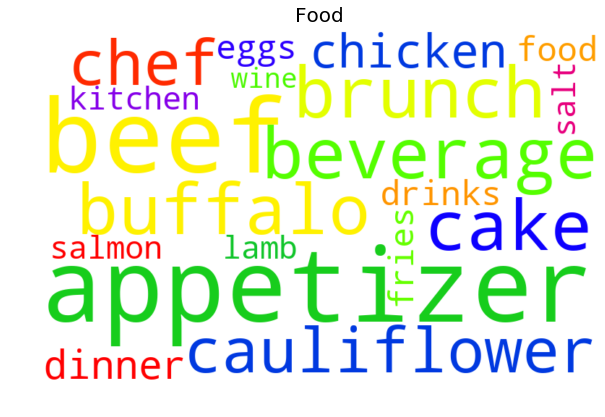

In [60]:
# For patina 250(restaurant) in food aspect

getWordCloud(' '.join(food), getEncode('thumb.jpg'), 'Food',figsize=(10,8))

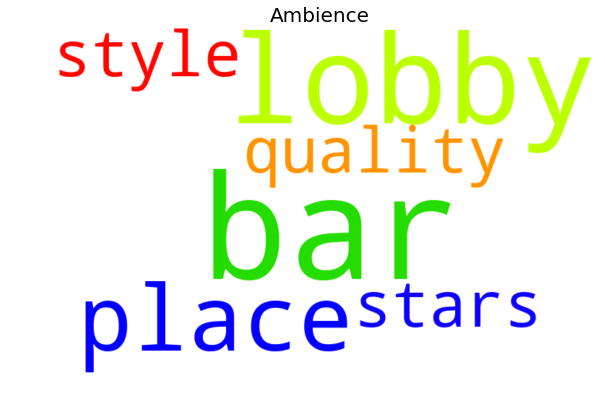

In [61]:
# For patina 250(restaurant) in Ambience aspect

getWordCloud(' '.join(ambience), getEncode('thumb.jpg'),'Ambience',figsize=(10,8))

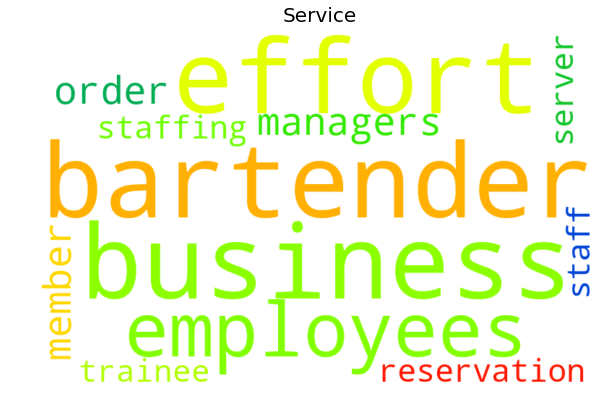

In [62]:
# For patina 250(restaurant) in Service aspect

getWordCloud(' '.join(service), getEncode('thumb.jpg'), 'Service',figsize=(10,8))

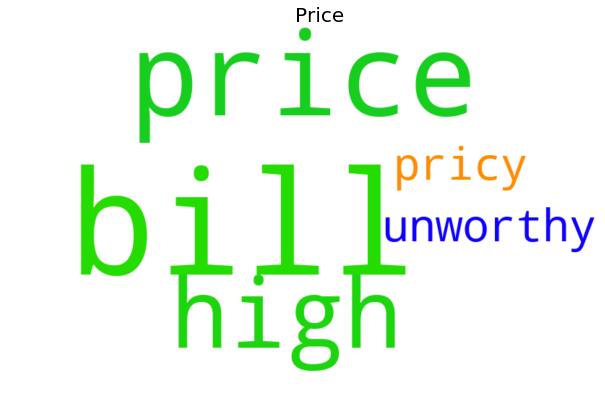

In [63]:
# For patina 250(restaurant) in Price aspect

getWordCloud(' '.join(price), getEncode('thumb.jpg'), 'Price',figsize=(10,8))

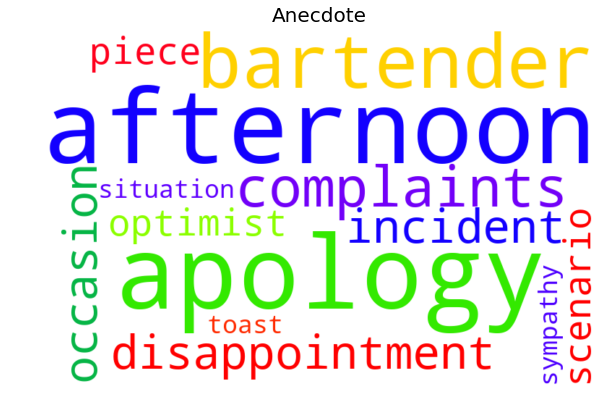

In [64]:
# For patina 250 in Anecdote aspect

getWordCloud(' '.join(anecdote), getEncode('thumb.jpg'), "Anecdote",figsize=(10,8))